In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from tensorflow.keras.utils import plot_model

In [2]:
from models import ImageCaptionModel, inception_model
from utils import add_end_start_tokens, clean_bad_text_data, create_vocab, _extract_feature

Call tf.config.experimental.set_memory_growth(GPU0, True)


In [3]:
with open('process_data/image_captoin_mapping_clean.pkl','rb') as f:
    image_captoin_mapping_clean= pickle.load(f)

image_captoin_mapping_with_token = add_end_start_tokens(image_captoin_mapping_clean)

vocab = create_vocab(image_captoin_mapping_with_token)
vocab[0:15]

['<start>',
 'a',
 'very',
 'clean',
 'and',
 'well',
 'decorated',
 'empty',
 'bathroom',
 '<end>',
 'blue',
 'white',
 'with',
 'butterfly',
 'themed']

In [4]:
with open('process_data/max_length.pkl','rb') as f:
    max_length = pickle.load(f)
max_length

15

In [5]:
inception_lstm = ImageCaptionModel(vocab)
model = inception_lstm.build_model(max_length=max_length)

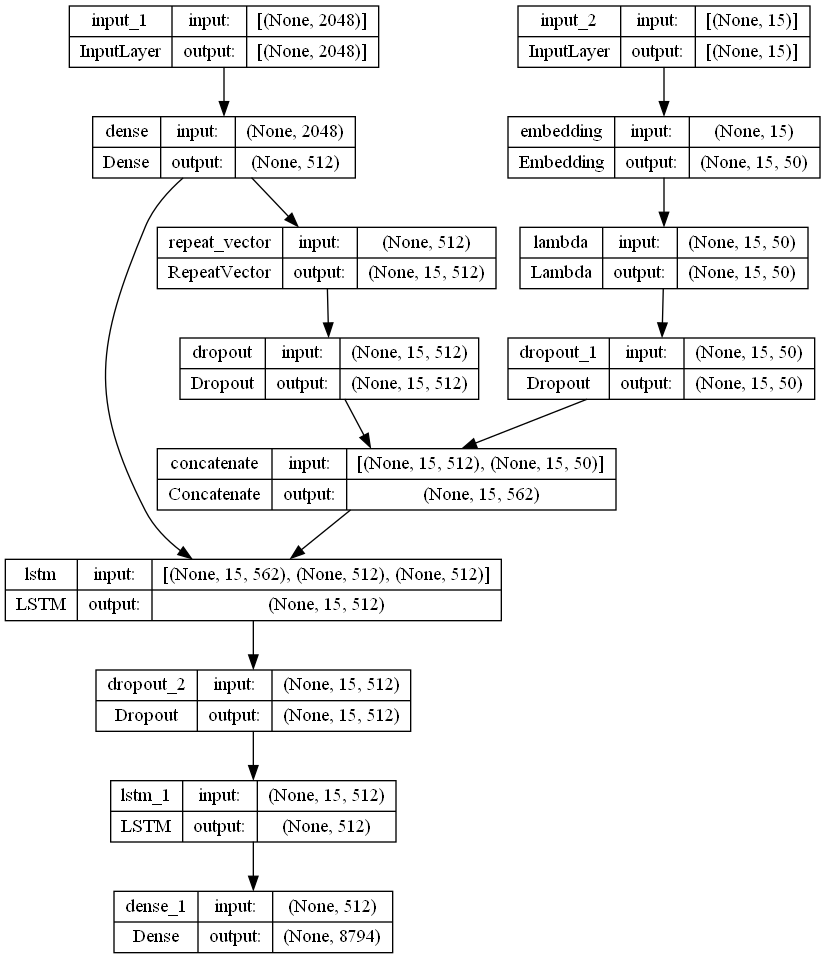

In [6]:
plot_model(model, to_file='model.png', show_shapes=True)

## Compare feature vector between InceptionNet V3 and HOG

In [7]:
def co_sim(a, b):
    """
    cosine similarity function to measure similarity of 2 feature vectors
    """
    return np.dot(a, b)/(norm(a)*norm(b))

In [8]:
def hog_model():
    cell_size = (8, 8)
    block_size = (2, 2)
    nbins = 9 # number of orientation bins
    img_size = (64,128)
    winSize = (img_size[1] // cell_size[1] * cell_size[1], img_size[0] // cell_size[0] * cell_size[0])
    blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
    blockStride = (cell_size[1], cell_size[0])
    n_cells = (img_size[0] // cell_size[0], img_size[1] // cell_size[1])
    hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)
    return hog

In [9]:
def _extract_hog_feature(path, hog_model, img_size=(128,64)):
    block_size = (2, 2)
    nbins = 9
    n_cells = (8, 16)
    img = cv2.imread(path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feats = hog_model.compute(img).reshape(n_cells[1] - block_size[1] + 1,
                                    n_cells[0] - block_size[0] + 1,
                                    block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))
    hog_feats = hog_feats.flatten()
    return hog_feats 

In [10]:
def _show_pair_image(base_url, list_pair, title = '', **kwargs):
    show_image_size = (200, 200)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7),subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        img1 = cv2.imread(base_url + '/' + list_pair[i][0])
        img2 = cv2.imread(base_url + '/' + list_pair[i][1])
        img1 = cv2.resize(img1, show_image_size)
        img2 = cv2.resize(img2, show_image_size)
        im_h = cv2.hconcat([img1, img2])
        im_h = cv2.cvtColor(im_h, cv2.COLOR_BGR2RGB)
        _inception_cs = kwargs.get('inception_co_sim', None)
        _hog_cs = kwargs.get('hog_co_sim', None)
        if _inception_cs:
            ax.set_title(f'InceptionNet : {str(round(_inception_cs[i], 2))}', loc='left')
        if _hog_cs:
            ax.set_title(f'HOG : {str(round(_hog_cs[i], 2))}', loc='right')
        ax.imshow(im_h)
    plt.tight_layout()
    fig.suptitle(title, fontsize=20)
    plt.show()

In [11]:
base_url = 'data/image_compare'
# Pair image
similar_pair_image = [('pair_1_1.jpg', 'pair_1_2.jpg'), ('pair_2_1.jpg', 'pair_2_2.png'), ('pair_3_1.jpg', 'pair_3_2.jpg'), ('pair_4_1.jpg', 'pair_4_2.jpg'), ('pair_5_1.jpg', 'pair_5_2.jpg'), ('pair_6_1.png', 'pair_6_2.png')]
totally_different_pair_image = [('pair_7_1.png', 'pair_7_2.png'), ('pair_8_1.png', 'pair_8_2.jpg'), ('pair_9_1.jpg', 'pair_9_2.jpg'), ('pair_10_1.jpg', 'pair_10_2.jpg'), ('pair_11_1.jpg', 'pair_11_2.jpg'), ('pair_12_1.jpg', 'pair_12_2.png')]

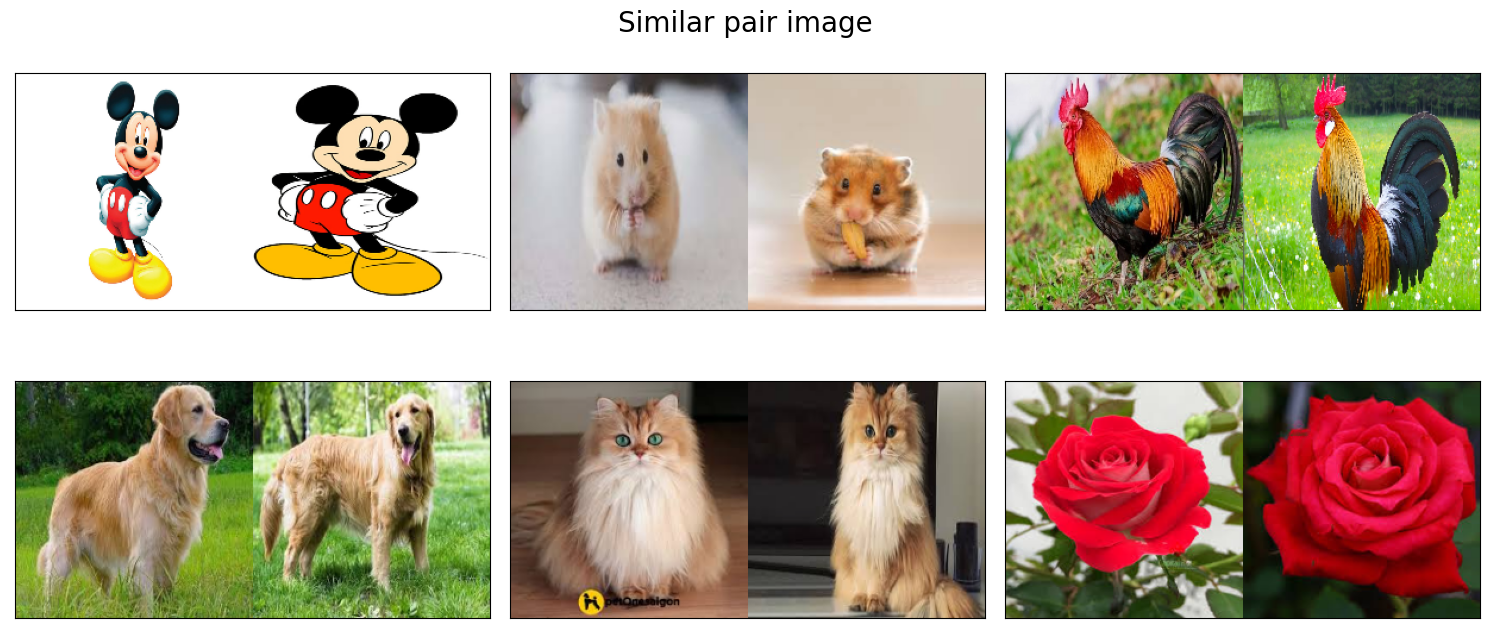

In [12]:
_show_pair_image(base_url, similar_pair_image, 'Similar pair image')

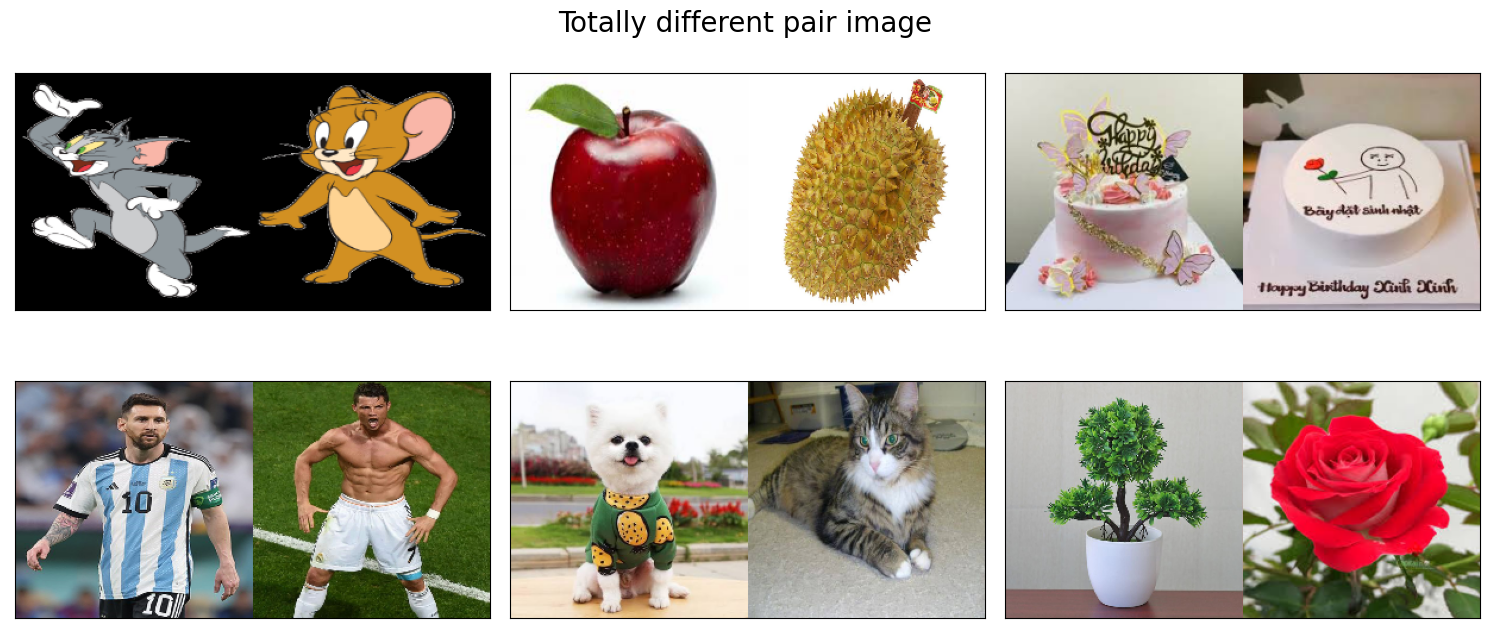

In [13]:
_show_pair_image(base_url, totally_different_pair_image, 'Totally different pair image')

In [14]:
# Inception Net model
_inception_net_model = inception_model()

# Hog model
_hog_model = hog_model()

In [15]:
def _get_cosim_value(base_url, list_pair):
    hog_cosim_value = {}
    inception_cosim_value = {}
    for i in range(1, len(list_pair) + 1):
        hog_cosim_value[f'pair_{i}'] = co_sim(_extract_hog_feature(base_url + '/' + list_pair[i-1][0], _hog_model), _extract_hog_feature(base_url + '/' + list_pair[i-1][1], _hog_model))
        inception_cosim_value[f'pair_{i}'] = co_sim(_extract_feature(base_url + '/' + list_pair[i-1][0], _inception_net_model), _extract_feature(base_url + '/' + list_pair[i-1][1], _inception_net_model))
    return hog_cosim_value, inception_cosim_value


In [65]:
similar_hog_cosim_value, similar_inception_cosim_value = _get_cosim_value(base_url, similar_pair_image)

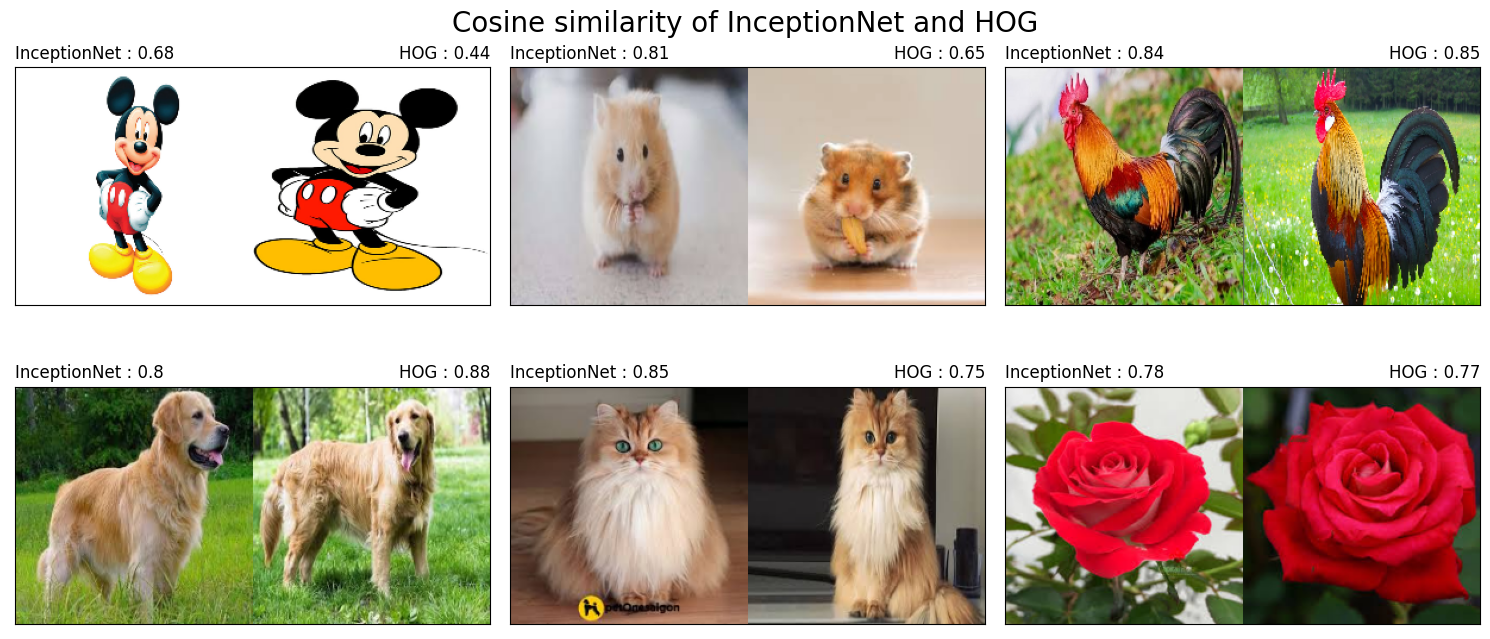

In [66]:
_show_pair_image(base_url, similar_pair_image, 'Cosine similarity of InceptionNet and HOG', hog_co_sim=list(similar_hog_cosim_value.values()), inception_co_sim=list(similar_inception_cosim_value.values()))

In [67]:
diff_hog_cosim_value, diff_inception_cosim_value = _get_cosim_value(base_url, totally_different_pair_image)

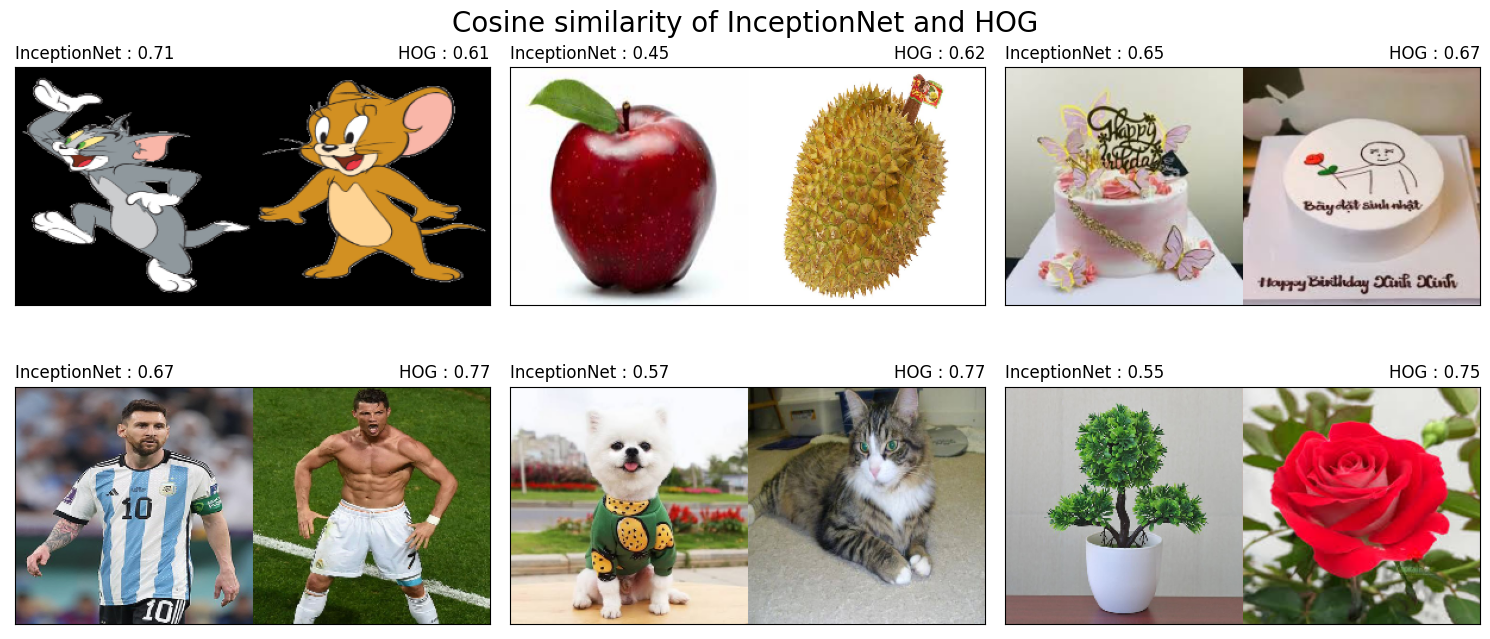

In [68]:
_show_pair_image(base_url, totally_different_pair_image, 'Cosine similarity of InceptionNet and HOG', hog_co_sim=list(diff_hog_cosim_value.values()), inception_co_sim=list(diff_inception_cosim_value.values()))

In [104]:

def eva_lot(x, y, title, sub_title, legends=['HOG', 'InceptionNet']):
    plt.figure(figsize = (12,6), dpi = 80)
    plt.plot(x, y[0], marker='o')
    plt.plot(x, y[1], marker='o')
    plt.title(sub_title, fontsize=14)
    plt.suptitle(title, y=0.99, fontsize=18)
    plt.xlabel('Pair images')
    plt.ylabel('Co-sin value')
    plt.legend(legends, loc=4)
    plt.grid(color='0.9')
    plt.show()

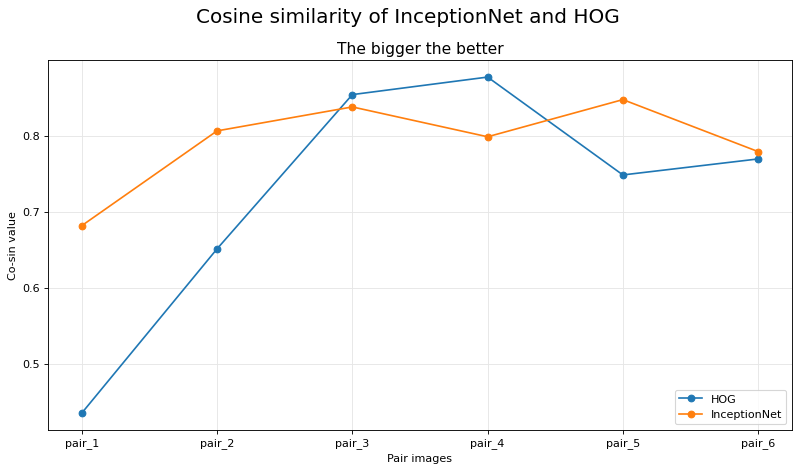

In [106]:
eva_lot(list(similar_hog_cosim_value.keys()), [list(similar_hog_cosim_value.values()), list(similar_inception_cosim_value.values())], 'Cosine similarity of InceptionNet and HOG', 'The bigger the better')

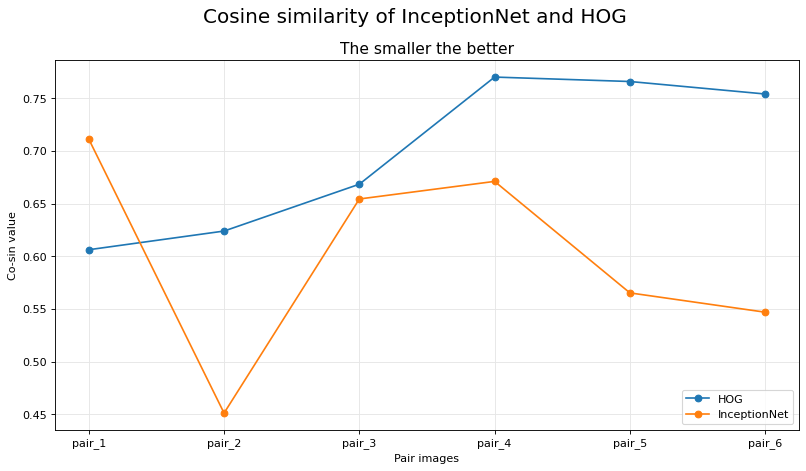

In [107]:
eva_lot(list(diff_hog_cosim_value.keys()), [list(diff_hog_cosim_value.values()), list(diff_inception_cosim_value.values())], 'Cosine similarity of InceptionNet and HOG', 'The smaller the better')

## Test Predict

In [86]:
import os
import cv2
import matplotlib.pyplot as plt
from textwrap import wrap

In [87]:
from predict import predict

Call tf.config.experimental.set_memory_growth(GPU0, True)


In [88]:
test_folder_url = 'data/test'

In [89]:
def _show_test_image(test_folder_url, weight, k_beam, mode):
    fix_height = 100
    max_width = 300
    list_pic = os.listdir(test_folder_url)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10),subplot_kw={'xticks': [], 'yticks': []})


    for i, ax in enumerate(axes.flat):
        im_url = test_folder_url + '/' + list_pic[i]
        caption = predict(path=im_url, weight=weight, k_beam=k_beam, mode=mode)
        img = cv2.imread(im_url)
        ratio = fix_height / img.shape[0]
        img = cv2.resize(img, (min(int(img.shape[1] * ratio), max_width) , fix_height), interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax.set_title('\n'.join(wrap(f'{caption[0].upper()}{caption[1:]}', 40)), loc='center', fontsize=12)

        ax.imshow(img)
    plt.tight_layout()
    fig.suptitle('Image Captioning', fontsize=20, y=1.05)
    plt.show()

### Dual Model (InceptionNet, LSTM and SSD300)

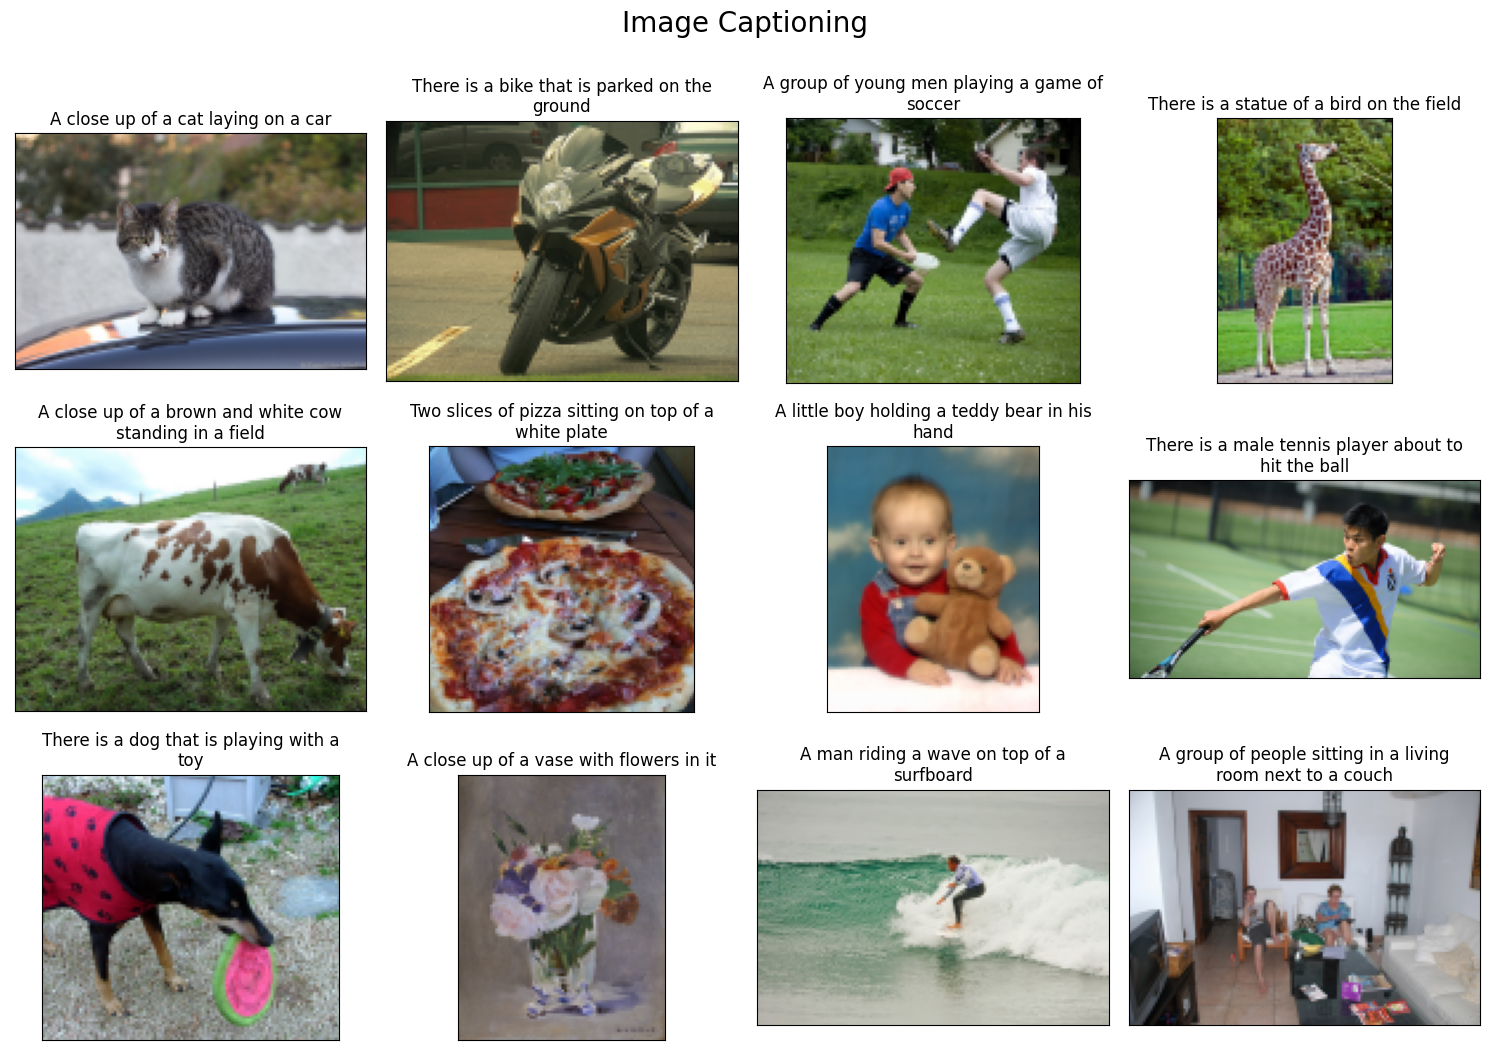

In [90]:
_show_test_image(test_folder_url, 'weights/model_65_dual.h5', 7, 'dual')

### Single Model (InceptionNet and LSTM)

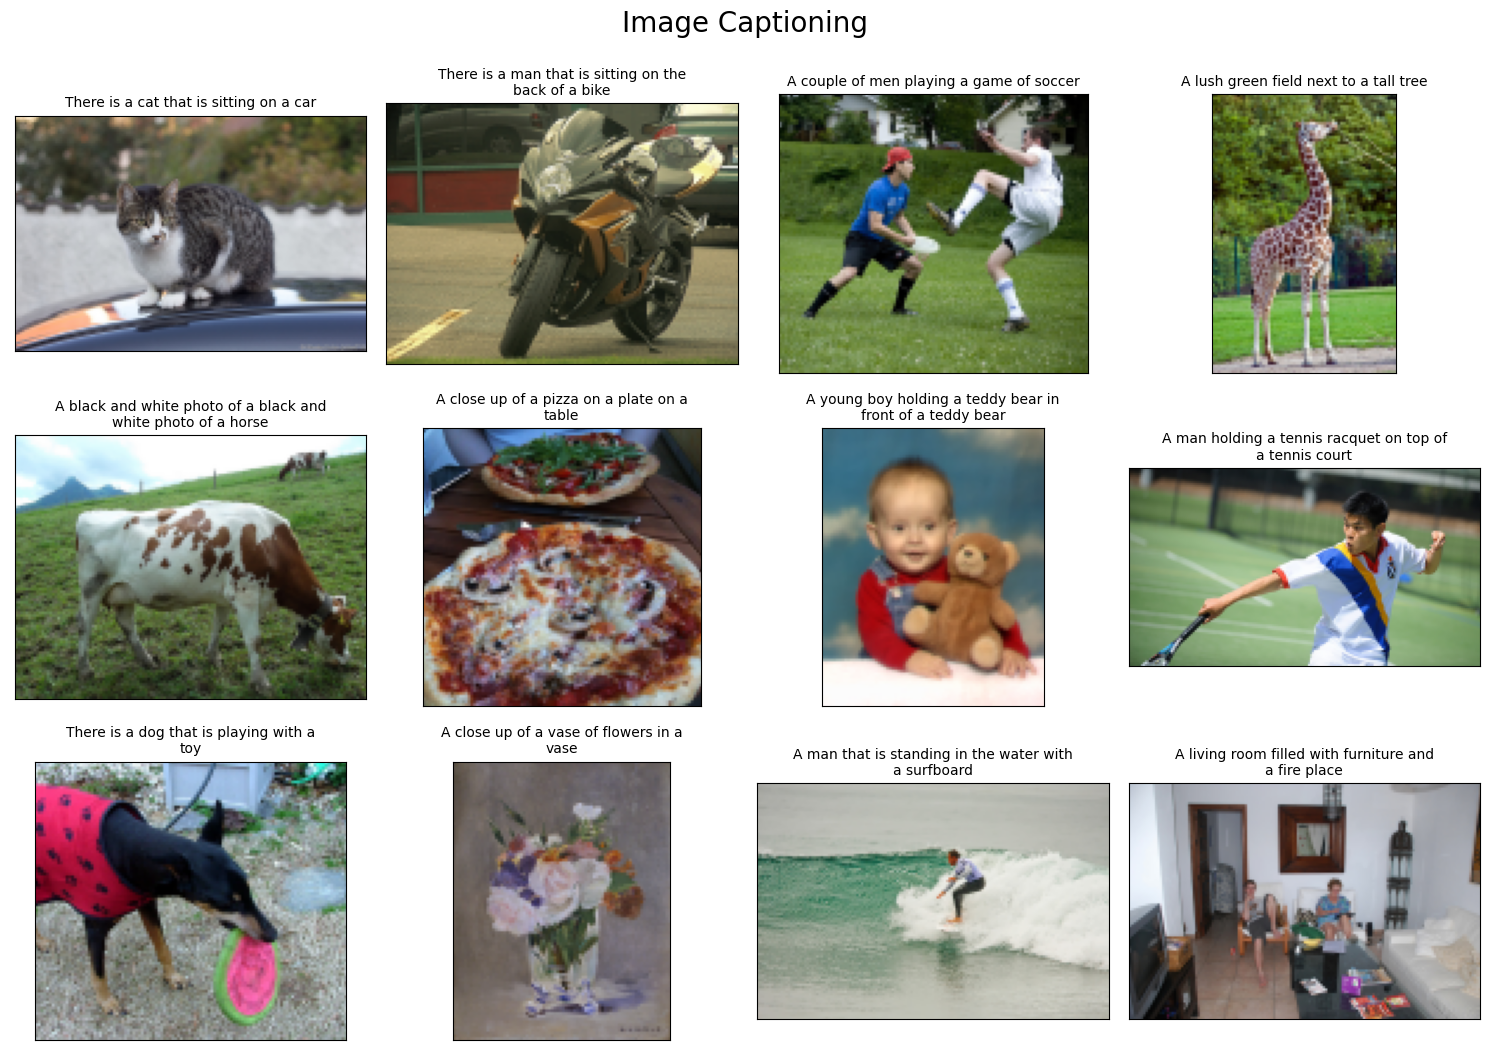

In [7]:
_show_test_image(test_folder_url, 'weights/model_65_single.h5', 7, 'single')

## Evaluate Model

In [16]:
import keras
import pickle
from evaluate import evaluate_model

from utils import add_end_start_tokens, train_test_split

In [17]:
weight_folder = 'weights/'

In [18]:
with open('process_data/image_captoin_mapping_clean.pkl','rb') as f:
    image_captoin_mapping_clean= pickle.load(f)

image_captoin_mapping_with_token = add_end_start_tokens(image_captoin_mapping_clean)

train_data, test_data = train_test_split(image_captoin_mapping_with_token)

### Single Model (InceptionNet and LSTM)

In [25]:
with open(f'process_data/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

model = keras.models.load_model(f'{weight_folder}model_65_single.h5', compile=False)
_b1, _b2, _b3, _b4, _score = evaluate_model(model, test_data, test_features)


100%|██████████| 8279/8279 [4:47:26<00:00,  2.08s/it]  


BLEU-1: 0.5551451454521912
BLEU-2: 0.3628118925102018
BLEU-3: 0.3278808792594959
BLEU-4: 0.24485688727731885
ROUGE:  {'rouge-1': {'r': 0.27562886088104177, 'p': 0.36614204600680594, 'f': 0.3112681549100461}, 'rouge-2': {'r': 0.1016538224969921, 'p': 0.1278478933395053, 'f': 0.11199733507805884}, 'rouge-l': {'r': 0.25333277407444527, 'p': 0.3361940483990748, 'f': 0.359894489723382}}


### Dual Model (InceptionNet, LSTM and SSD 300)

In [22]:
with open(f'process_data/test_combine_features.pkl','rb') as f:
    test_features= pickle.load(f)

model = keras.models.load_model(f'{weight_folder}model_65_dual.h5', compile=False)
b1, b2, b3, b4, score = evaluate_model(model, test_data, test_features, mode='dual')


100%|██████████| 8279/8279 [4:43:05<00:00,  2.05s/it]  


BLEU-1: 0.6078702759038914
BLEU-2: 0.4866108320562466
BLEU-3: 0.38480739428283936
BLEU-4: 0.3231681090732135
ROUGE:  {'rouge-1': {'r': 0.27453999563840636, 'p': 0.36600964140344755, 'f': 0.3105496363490308}, 'rouge-2': {'r': 0.09977645003401156, 'p': 0.12780314966268133, 'f': 0.11077428326112738}, 'rouge-l': {'r': 0.2525559732947724, 'p': 0.3366945163787009, 'f': 0.46925540905021}}


In [2]:
v1 = [_b1, _b2, _b3, _b4, _score.get('rouge-l').get('f')]
v2 = [b1, b2, b3, b4, score.get('rouge-l').get('f')]
x = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-L']

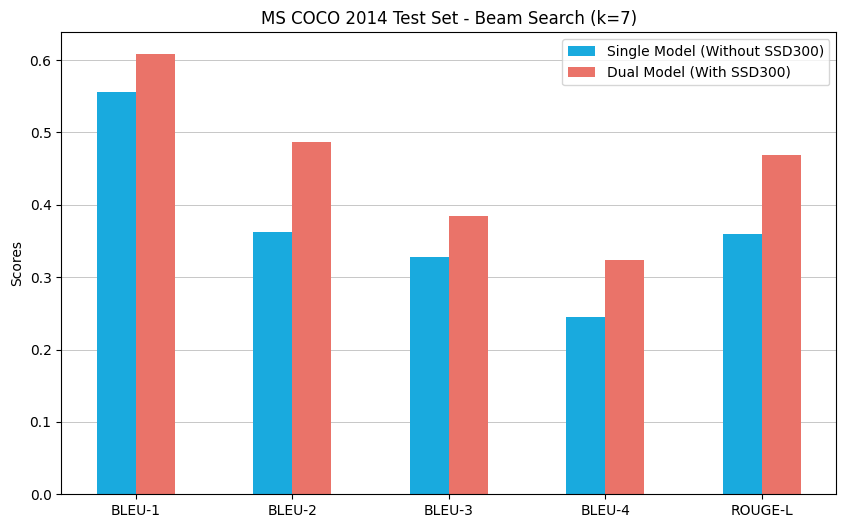

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10,6), dpi=100)

index = np.arange(len(x))
width = 0.25

bar1 = plt.bar(index, v1, color = '#19AADE',
        width = width,
        label='Single Model (Without SSD300)')
bar2 = plt.bar(index + width, v2, color = '#EA7369',
        width = width,
        label='Dual Model (With SSD300)')
  
plt.xlabel("")
plt.ylabel('Scores')
plt.title("MS COCO 2014 Test Set - Beam Search (k=7)")
  
plt.xticks(index + width / 2, x)
plt.legend()
ax.set_axisbelow(True)
ax.grid(axis='y', linewidth=0.5)
plt.show()

### Compare with OFA model

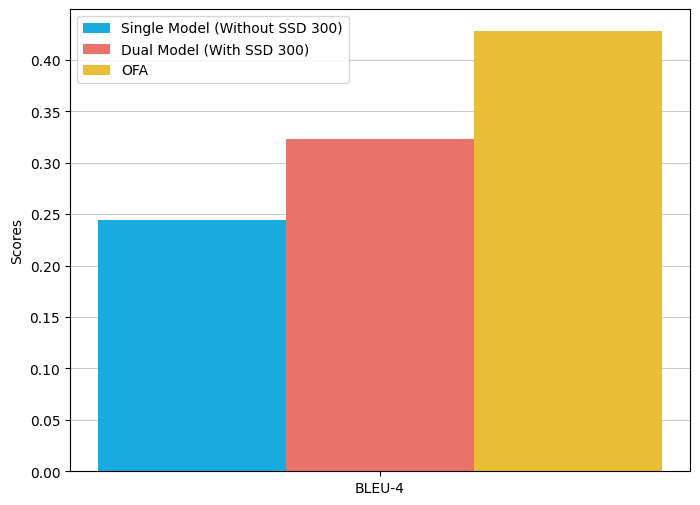

In [4]:
bleu_4_OFA = 0.428
bleu_4_v1 = _b4
bleu_4_v2 = b4


fig, ax = plt.subplots(figsize=(8,6), dpi=100)

width = 0.25

bar1 = plt.bar(0, bleu_4_v1, color = '#19AADE',
        width = width,
        label='Single Model (Without SSD 300)')

bar2 = plt.bar(width, bleu_4_v2, color = '#EA7369',
        width = width,
        label='Dual Model (With SSD 300)')

bar2 = plt.bar(width*2, bleu_4_OFA, color = '#EABD36',
        width = width,
        label='OFA')
  
plt.xlabel("")
plt.ylabel('Scores')
  
plt.xticks([0.25], ['BLEU-4'])
ax.set_axisbelow(True)
ax.grid(axis='y', linewidth=0.5)
plt.legend()
plt.show()